In [1]:
import pandas as pd
import numpy as np
from function_wrappers import *
from functions import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from functions import hyperparameter_grid

def hyperparameter_grid(stock,year_train,w_array,d_array,test,measure):
    hp = {}
    for d in d_array:
        for w in w_array:
            hp[(d,w)] = polynomial_accuracy(stock,y=year_train,w=w,d=d,
                            test=test, measure=measure)[0]  
    accuracies_df = pd.DataFrame([tuple(list(k)+[hp[k]]) for k in hp.keys()],
                                 columns = ['d','w','accuracy'])
    return accuracies_df

## Trading With Linear Models

###### Description

In this assignment you will implement and compare three poly- nomial functions (line - degree d = 1, quadratic - degree d = 2 and cubic - degree d = 3) for predicting next week labels based on the previous W weekly closing prices. Recall that a weekly closing price for week i is the (adjusted) closing price Pi for the last trading day day of that week.
Assume that you are given W and you have weekly closing prices P1,...,PW for weeks 1,...,W. You want to predict a label (”red” or ”green”) for week W + 1 using a polynomial model of degree d fitted on prices P1,...,PW.
You proceed as follows. Construct a polynomial model of de-
gree d to fit P1,...,PW and use this model to predict price
P∗ for week W +1. Then assign a label to week W +1
based on the following three cases:
1. P∗ > PW: week W +1 ia assigned a ”green” color (you
W+1
predict next week closing price is higher than current, and
therefore, you want to be invested)
2. P∗ < PW: week W + 1 ia assigned a ”red” color (you
W+1
predict next week closing price to be lower than the current
price, and therefore, you want to remain in cash)
3. P∗ = PW: week W + 1 ia assigned the same color as W+1
week W

In [2]:
gme = pd.read_csv('./gme.csv')
gme.drop(['Date', 'Month', 'Day','Week_Number','High', 'Low', 'Close', 'Volume', 
         'Short_MA', 'Long_MA'], inplace=True, axis=1)

In [3]:
head_tail(gme,2)

,Year,Weekday,Year_Week,Open,Adj Close,Return
0,2017,Tuesday,2017-01,6.36,5.16,0.000000
1,2017,Wednesday,2017-01,6.39,5.27,0.021679
1256,2021,Wednesday,2021-52,36.96,38.48,0.051004
1257,2021,Thursday,2021-52,37.75,38.83,0.009095


### Question 1
Take weekly data for year 1. For each W = 5,6,...,12 and for each d = 1, 2, 3 construct the corresponding polynomials Use these polynomials to predict weekly labels. Plot the accuracy - on x axis you have W and you plot three curves for accuracy (separate curve for each d)

In my estimation, using lagged returns makes the most sense.

In effect, the coefficients with Adj Close would represent equal-weighted return factors for the lagged adjusted close numbers. Thus, a least squares estimation is modeling return projections for each lagged week.

Modeling with returns as the lagged figure, however, captures momentum effects.  For a stock with extreme volatility, and for any stock undergoing a time of great volatility, it seems to make sense to not model for a constant underlying force of return, but rather to capture patterns in the direction and magnitude of price changes.

In addition, I would expect increasing skedasticity over time with Adj Close.

**function graph**
stagger_weeks --> trade_from_close_close

X_matrix|args:sw, y, w, measure|return:X_lags --> poly_expansion|args:X,D|return:X_pe --> add_intercept|args:X_pe|return|X_i_pe
    --> polynomial_accuracy()


In [4]:
gme_wr = trade_from_close_close(gme)
gme_labels = pd.read_csv('./gme_labels.csv',header=None)[0]
gme_wr.loc[:,'Label'] = "NoLabel"
# apply labels collected by visual inspection for last two years
gme_wr.loc[gme_wr.shape[0] - gme_labels.shape[0]:,'Label'] = gme_labels.values

In [5]:
head_tail(gme_wr)

,Year,Year_Week,Begin_Price,Adj Close,Return,Label
0,2017,2017-01,6.36,4.99,0.784591,NoLabel
1,2017,2017-02,4.99,4.62,0.925852,NoLabel
261,2021,2021-51,38.91,38.03,0.977384,Red
262,2021,2021-52,38.03,38.83,1.021036,Red


def poly_predict(stock_weekly_df, W, d, begin_y_wk):
    """Args: stock_weekly_df --> weekly stock data, with W weeks before 
                begin_y_wk included
             W --> int, number of preceding weeks used in predicting labels
             d --> int, degree of polynomial used in predicting labels
             begin_y_wk --> str, 
                this is the first week (with year identifier) for
                which a prediction will be made.
        Return: predictions --> np.array, 
                    label of 'Green' if predicted price > prior 
                    week's price, otherwise 'Red' for each week beginning with
                    begin_y_wk
    """
    
    mask = stock_weekly_df['Year_Week'].values == begin_y_wk
    begin_inx = stock_weekly_df[mask].index[0]
    le = LabelEncoder()
    stock_weekly_df['Label'] = le.fit_transform(
                                  stock_weekly_df['Label'][begin_inx:])
    for i in range(begin_inx,stock_weekly_df.index[-1]+1):
        X = stock_weekly_df['Adj Close'][i-w:i].values
        X = np.asarray(X,dtype='float64')
        y = le.fit_transform(stock_weekly_df['Label'][i-w:i].values)
        pfit = np.polyfit(X,X_labs)
        

test = gme_wr.copy(deep=True)

test[100:200].reindex(index=[i for i in range(0,100)])

In [6]:
d='dog'
print(d)

dog


def X_matrix(stock_w, y = 2020, w = 5, measure = 'Adj Close'):
    """Return a matrix of weekly lagged values for a given feature."""
    (begin,stop) = (stock_w[stock_w['Year']==y].index[0],
                    stock_w[stock_w['Year']==y].index[-1]+1)
    X_lags = [stock_w[f'{measure}'][i-w:i].values for i in range(begin,stop)]
    return X_lags

def poly_expansion(X,d):
    """Return a polynomially expanded matrix."""
    X_pe = [[x_i**d_i for d_i in range(1,d+1) for x_i in x] for x in X]
    return X_pe

def add_intercept(X_pe):
    """Return matrix with intercept prepended to each row."""
    X_pe = np.asarray(X_pe, dtype = 'float64')
    X_i_pe = np.vstack([np.ones(len(X_pe)),X_pe.T]).T
    return X_i_pe

def labeler(differences):
        """Return labels for weekly price movements: 1 for up, 0 for down."""
        labels = np.where(differences > 0, 1, 0)
        shifted = np.delete(np.insert(labels,0,1),-1)
        labels = np.where(differences == 0, shifted, labels)
        return labels

def X_transform(stock, y = 2020, w = 5, d = 2, measure = 'Adj Close'):
    """Return a matrix for which coefficients will be fit."""
    stock_wr = trade_from_close_close(stock)
    return np.asarray(add_intercept(
        poly_expansion(X_matrix(stock_wr,y=y,w=w,measure=measure),d=d)), dtype='float64')

def polynomial_accuracy(stock,y = 2020, w = 5, d = 2, test = 1, measure = 'Adj Close', 
                        **kwargs):
    """Return the accuracy, np.lstsq results, and a tuple of predictions, 
    true labels, and false labels for a particular model formulation."""
    (y1,y2) = (y,y+test)
    X_tr = X_transform(stock,y=y1,w=w,d=d,measure=measure)
    X_te = X_transform(stock,y=y2,w=w,d=d,measure=measure)
    stock_weekly = trade_from_close_close(stock)
    y_tr = np.asarray(stock_weekly[stock_weekly['Year'] == y1][measure].values,
                      dtype='float64')
    y_te = np.asarray(stock_weekly[stock_weekly['Year'] == y2][measure].values,
                     dtype='float64')
    lstsq_results = np.linalg.lstsq(X_tr,y_tr,rcond=1.e-10)
    coeffs = lstsq_results[0]
    predictions = X_te @ coeffs
    modeled_difference = predictions - stock_weekly.loc[stock_weekly[
        stock_weekly.Year == y2].index -1,f'{measure}'].values
    actual_difference  = stock_weekly[stock_weekly.Year == y2][f'{measure}'].values - \
    stock_weekly.loc[stock_weekly[
        stock_weekly.Year == y2].index -1,f'{measure}'].values
    return (accuracy_score(labeler(actual_difference),
                          labeler(modeled_difference)),lstsq_results,
            {'predictions' : predictions,
             'true_labels':labeler(actual_difference),
             'predicted_labels':labeler(modeled_difference)})

In [7]:
gme

,Year,Weekday,Year_Week,Open,Adj Close,Return
0,2017,Tuesday,2017-01,6.36,5.16,0.000000
1,2017,Wednesday,2017-01,6.39,5.27,0.021679
2,2017,Thursday,2017-01,6.39,5.08,-0.035494
3,2017,Friday,2017-01,6.29,4.99,-0.019200
4,2017,Monday,2017-02,6.15,4.98,-0.001224
...,...,...,...,...,...,...
1253,2021,Thursday,2021-51,38.50,38.03,-0.012078
1254,2021,Monday,2021-52,38.00,37.08,-0.025174
1255,2021,Tuesday,2021-52,36.88,36.62,-0.012474
1256,2021,Wednesday,2021-52,36.96,38.48,0.051004


In [8]:
# kwargs = {'measure':'Return'}
polynomial_accuracy(gme,y=2020,w=12,d=2,test=1,measure='Adj Close')

(0.6346153846153846,
 (array([-0.29176939, -0.06926889,  2.7415555 , -2.28008671, -0.3123587 ,
         -0.3250952 , -0.01000644, -0.40643333,  1.40808787, -1.6806441 ,
          0.70022227,  0.74677353,  1.05574585,  0.01167137, -1.16628998,
          0.88037389,  0.20536297, -0.04533966,  0.10993331,  0.09390152,
         -0.33059528,  0.40776358, -0.21372554, -0.12103101, -0.05661988]),
  array([2.44196263]),
  25,
  array([115.41357582,  21.07023087,  15.95727443,  14.87298937,
          14.01182662,  13.40354431,   8.41230283,   7.46415907,
           7.0349563 ,   5.55324033,   4.60705995,   2.75186952,
           2.35763573,   0.99521524,   0.77069006,   0.6704491 ,
           0.57339904,   0.49677756,   0.46138305,   0.36557974,
           0.31616771,   0.25903354,   0.23493495,   0.14754278,
           0.12801684])),
 {'predictions': array([-2.98626042e+00,  3.82756920e+00,  5.28017736e+00, -1.06653494e+00,
         -3.14300843e+02, -7.63920289e+02, -1.30781909e+03,  2.4490292

It is curious that scores improve in year 2.  One would typically expect a decline in performance as one extrapolates a model into the test set.  This indicates that stock returns fall more predictably in line with y1 averages

def hyperparameter_grid(stock,year_train,w_array,d_array,test,measure):
    hp = {}
    for d in d_array:
        for w in w_array:
            hp[(d,w)] = polynomial_accuracy(stock,y=year_train,w=w,d=d,
                            test=test, measure=measure)[0]
    
    accuracies_df = pd.DataFrame([tuple(list(k)+[hp[k]]) for k in hp.keys()],
                                 columns = ['d','w','accuracy'])
    return accuracies_df

In [9]:
hp_adj_train = hyperparameter_grid(gme, 2020, range(5,13), range(1,4), 0, 'Adj Close')
hp_ret_train = hyperparameter_grid(gme, 2020, range(5,13), range(1,4), 0, 'Return')
hp_adj_test = hyperparameter_grid(gme, 2020, range(5,13), range(1,4), 1, 'Adj Close')
hp_ret_test = hyperparameter_grid(gme, 2020, range(5,13), range(1,4), 1, 'Return')
hp_frames = [hp_adj_train,hp_ret_train,hp_adj_test,hp_ret_test]

frame_names=["Adj_Close_Tr","Return_Tr","Adj_Close_Te","Return_Te"]
frame_features=['d','w','accuracy']
mi = pd.MultiIndex.from_tuples(zip([name*3 for name in frame_names],['d','w','accuracy']*4
                                  ))
hp_accuracies = pd.concat([hp_frame['accuracy'] for hp_frame in hp_frames],
                          axis=1,keys=frame_names,names=['Measure_EvalSet'])
hp_accuracies.index=pd.MultiIndex.from_tuples(
    [(d,w) for d in range(1,4) for w in range (5,13)],names=('d','w'))

hp_accuracies_stacked = pd.DataFrame(hp_accuracies.stack()).reset_index()

hp_accuracies_stacked = hp_accuracies_stacked.rename(columns={0:"Accuracy"})

hp_accuracies_stacked['EvalSet'] = hp_accuracies_stacked['Measure_EvalSet'].apply(
    lambda x: 'Train' if x[-2:] == 'Tr' else 'Test')

hp_accuracies_stacked['Measure'] = hp_accuracies_stacked['Measure_EvalSet'].apply(lambda x: x[:-3])

hp_accuracies_stacked.head()

,d,w,Measure_EvalSet,Accuracy,EvalSet,Measure
0,1,5,Adj_Close_Tr,0.547170,Train,Adj_Close
1,1,5,Return_Tr,0.698113,Train,Return
2,1,5,Adj_Close_Te,0.384615,Test,Adj_Close
3,1,5,Return_Te,0.750000,Test,Return
4,1,6,Adj_Close_Tr,0.547170,Train,Adj_Close


/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


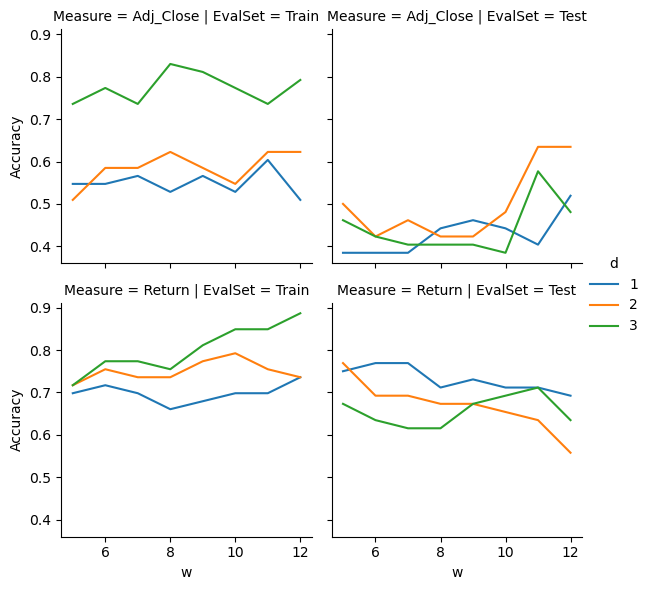

In [10]:
g = sns.FacetGrid(data=hp_accuracies_stacked,
              row = 'Measure', 
              col='EvalSet',
              hue='d'
             )
g.map(plt.plot,'w','Accuracy').add_legend()
plt.show()

In [11]:
best_w = hp_adj_train.iloc[hp_adj_train.groupby('d')["accuracy"].idxmax().values,:]
best_w_dict={d:w for d,w in zip(best_w['d'],best_w['w'])}
best_w_dict

{1: 11, 2: 8, 3: 8}

In [12]:
cm_dict = {}
for k,v in best_w_dict.items():
    
    res = polynomial_accuracy(gme,2020,w=best_w_dict[k],d=k,test=1,measure="Adj Close")[-1]
    
    cm = confusion_matrix(res['true_labels'],res['predicted_labels'])
    cm_dict[(k,v)] = cm

In [13]:
cm_dict

{(1,
  11): array([[ 9, 23],
        [ 8, 12]]),
 (2,
  8): array([[ 6, 26],
        [ 4, 16]]),
 (3,
  8): array([[ 4, 28],
        [ 3, 17]])}

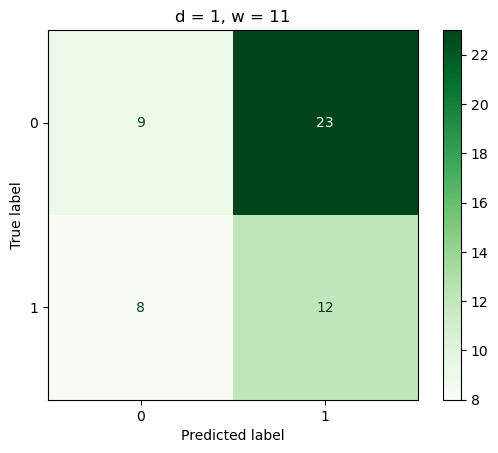

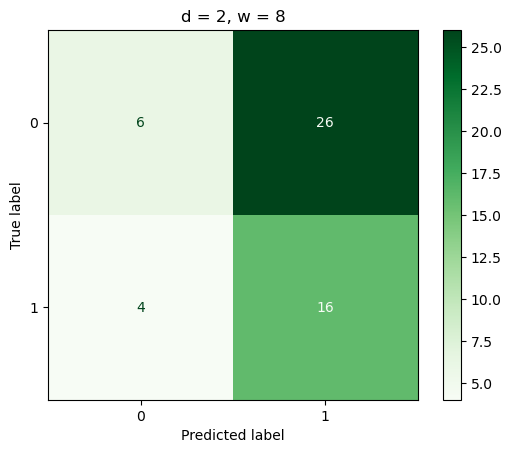

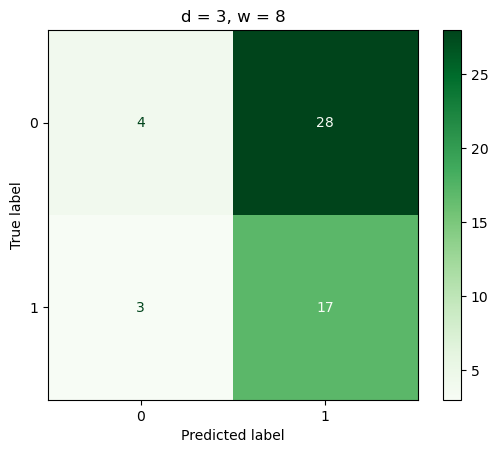

In [14]:
for cm_k,cm_v in cm_dict.items():
    display = ConfusionMatrixDisplay(cm_v)
    display.plot(cmap='Greens')
    display.ax_.set_title(f'd = {cm_k[0]}, w = {cm_k[1]}')
    plt.show()

In [15]:
hp_adj_test.iloc[hp_adj_test.groupby('d')["accuracy"].idxmax().values,:]

,d,w,accuracy
7,1,12,0.519231
14,2,11,0.634615
22,3,11,0.576923


In [16]:
hp_ret_train.iloc[hp_ret_train.groupby('d')["accuracy"].idxmax().values,:]

,d,w,accuracy
7,1,12,0.735849
13,2,10,0.792453
23,3,12,0.886792


In [17]:
hp_ret_test.iloc[hp_ret_test.groupby('d')["accuracy"].idxmax().values,:]

,d,w,accuracy
1,1,6,0.769231
8,2,5,0.769231
22,3,11,0.711538


Confusion Matrix

In [18]:
best_w_dict

{1: 11, 2: 8, 3: 8}

In [19]:
gme

,Year,Weekday,Year_Week,Open,Adj Close,Return
0,2017,Tuesday,2017-01,6.36,5.16,0.000000
1,2017,Wednesday,2017-01,6.39,5.27,0.021679
2,2017,Thursday,2017-01,6.39,5.08,-0.035494
3,2017,Friday,2017-01,6.29,4.99,-0.019200
4,2017,Monday,2017-02,6.15,4.98,-0.001224
...,...,...,...,...,...,...
1253,2021,Thursday,2021-51,38.50,38.03,-0.012078
1254,2021,Monday,2021-52,38.00,37.08,-0.025174
1255,2021,Tuesday,2021-52,36.88,36.62,-0.012474
1256,2021,Wednesday,2021-52,36.96,38.48,0.051004


In [20]:
polynomial_accuracy(gme,y=2020,w=5,d=2,test=1,measure='Adj Close')

(0.5,
 (array([-0.11681723,  0.21470095, -0.88987274, -0.36924028,  0.96910938,
          1.19234287, -0.00781882,  0.18402363,  0.0949477 , -0.16152716,
         -0.098184  ]),
  array([4.97342897]),
  11,
  array([93.62607135, 15.21564215, 13.91347537, 11.66739531,  8.42769351,
          7.35604419,  1.08806676,  0.7278439 ,  0.53789346,  0.48014516,
          0.43067755])),
 {'predictions': array([   3.95423825,    4.72942067,    5.13344099,   -9.80191852,
         -573.60408233, -967.17212398,  605.28541096, 1149.05047533,
          -30.23632197, -127.93000317, -445.33005234, -631.00802628,
           75.08534089,  508.51859749,  144.09706486,  211.85913431,
          207.49651627,   45.91567262,  -14.92082389,   56.17516449,
           85.45275097, -114.78101688, -324.65670055, -238.93044987,
          144.74737196,  326.65574197,  224.47181422,  171.68265393,
          224.89273504,  223.77281999,  126.7450689 ,  140.57744028,
          158.80774635,   43.51618417,  -45.62938169,

In [21]:
predictions={}
for d,w in best_w_dict.items():
    predictions[(d,w)] = polynomial_accuracy(gme,2020,d=d,w=w,test=1,measure='Adj Close')[-1]['predicted_labels']

In [22]:
predictions

{(1,
  11): array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0]),
 (2,
  8): array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 (3,
  8): array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])}

In [23]:
gme_wr = trade_from_close_close(gme).query('Year == 2021')
returns = {}
for d_w,p in predictions.items():
    returns[d_w] = trade_labels(gme_wr,2021,p)

In [24]:
returns

{(1, 11): 431.28, (2, 8): 613.26, (3, 8): 743.51}

## Trading Linear Regression Best Window

###### Assignment

Take a window of W days.  Train a linear model on "Adj Close" prices with W days lagged.  Determine if the next day will be higher or lower than today.  Enter or stay in a position that is either long, short, or neutral depending on whether the price is expected to be higher, lower or the same.  Optimize for W according to returns in year 2.


###### Questions


1. take W = 5, 6, . . . , 30 and consider your data for year 1.
For each W in the specified range, compute your average
P/L per trade and plot it: on x-axis you plot the values
of W and on the y axis you plot profit and loss per trade.
What is the optimal value W∗
of W?
2. use the value of W∗
from year 1 and consider year 2. For
every day in year 2, take the previous W∗ days, compute
linear regression and compute the value of r
2
for that day.
Plot the graph of r
2
for year 2. What is the average r
2
.
How well does it explain price movements?
3. take the optimal value of W∗
from year 1 and use it to
implement the above trading strategy for year 2. How many
”long position” and ’short position” transactions did you
have in year 2?
4. what is the average profit/loss per ”long position” trade
and per ”short position” trades in year 2?
5. what is the average number of days for long position and
short position transactions in year 2?
6. are these results very different from those in year 1 for this
value of W∗
?

In [25]:
gme[gme['Year']==2020].index[0]

754

In [26]:
X_transform(gme,y=2020,w=5,d=1,measure='Adj Close')

array([[1.  , 1.36, 1.35, 1.48, 1.53, 1.52],
       [1.  , 1.35, 1.48, 1.53, 1.52, 1.58],
       [1.  , 1.48, 1.53, 1.52, 1.58, 1.47],
       ...,
       [1.  , 3.88, 4.86, 5.14, 5.04, 5.25],
       [1.  , 4.86, 5.14, 5.04, 5.25, 4.84],
       [1.  , 5.14, 5.04, 5.25, 4.84, 4.82]])

In [27]:
gme["Adj Close"]

0        5.16
1        5.27
2        5.08
3        4.99
4        4.98
        ...  
1253    38.03
1254    37.08
1255    36.62
1256    38.48
1257    38.83
Name: Adj Close, Length: 1258, dtype: float64